In [38]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [39]:
import utils_generic as generic
import rrnn_modelo as rrnn
import st_dep as st
import train_datamaps_inprogress as train

from train import eval_func

In [40]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoding_type = 'brk'
model_name = 'rnn'

# Datos ConvAI2

In [41]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [42]:
vocab_dep = generic.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [43]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [44]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [45]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [46]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [47]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [48]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [49]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

In [50]:
emb_dim = 100
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

## ABOUT

In [51]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6745360109448848 	 Validation loss: 0.6582503864320658 	 
  1%|          | 574/57400 [00:09<14:05, 67.25it/s]
Epoch 2 	 Training loss: 0.6257699262805101 	 Validation loss: 0.6075618863105774 	 
  2%|▏         | 1148/57400 [00:18<14:34, 64.33it/s]
Epoch 3 	 Training loss: 0.5858719564377223 	 Validation loss: 0.5804137819904392 	 
  3%|▎         | 1722/57400 [00:27<14:37, 63.42it/s]
Epoch 4 	 Training loss: 0.5582470779634934 	 Validation loss: 0.5604033237796718 	 
  4%|▍         | 2296/57400 [00:36<13:40, 67.13it/s]
Epoch 5 	 Training loss: 0.5347320025702387 	 Validation loss: 0.5433226086325564 	 
  5%|▌         | 2870/57400 [00:45<13:59, 64.99it/s]
Epoch 6 	 Training loss: 0.5145974641062241 	 Validation loss: 0.5314513298414522 	 
  6%|▌         | 3444/57400 [00:55<13:42, 65.61it/s]
Epoch 7 	 Training loss: 0.4972161468416972 	 Validation loss: 0.5161277843733966 	 
  7%|▋         | 4018/57400 [01:04<13:49, 64.37it/s]
Epoch 8 	 Training loss: 0.48227671

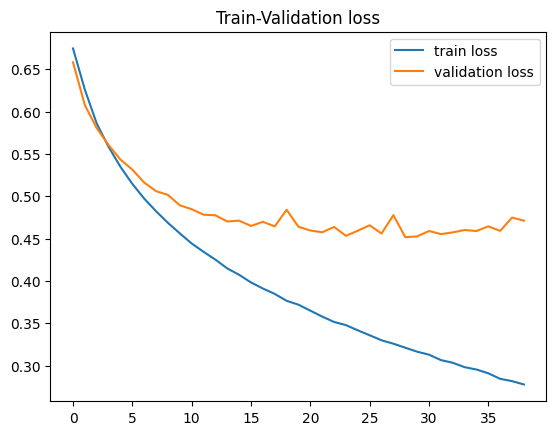

In [52]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_about'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [53]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.645, 'male': 0.8411458333333334, 'average': 0.7430729166666667}
precision {'female': 0.8087774294670846, 'male': 0.6946236559139785, 'average': 0.7517005426905315}
f1 {'female': 0.717663421418637, 'male': 0.7608951707891638, 'average': 0.7392792961039004}
accuracy 0.7410714285714286


Evaluación en el conjunto el conjunto to
recall {'female': 0.4776902887139108, 'male': 0.6958637469586375, 'average': 0.5867770178362741}
precision {'female': 0.5928338762214984, 'male': 0.5896907216494846, 'average': 0.5912622989354914}
f1 {'female': 0.5290697674418605, 'male': 0.6383928571428572, 'average': 0.5837313122923589}
accuracy 0.5909090909090909


Evaluación en el conjunto el conjunto as
recall {'female': 0.5336927223719676, 'male': 0.7070707070707071, 'average': 0.6203817147213373}
precision {'female': 0.6305732484076433, 'male': 0.6181015452538632, 'average': 0.6243373968307533}
f1 {'female': 0.5781021897810219, 'male': 0.65959

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6745194653600766 	 Validation loss: 0.656513185824378 	 
  1%|          | 574/57400 [00:09<14:38, 64.71it/s]
Epoch 2 	 Training loss: 0.624332477822121 	 Validation loss: 0.6052045933270859 	 
  2%|▏         | 1148/57400 [00:18<14:39, 63.99it/s]
Epoch 3 	 Training loss: 0.5856360097899255 	 Validation loss: 0.5751222856974197 	 
  3%|▎         | 1722/57400 [00:28<15:59, 58.03it/s]
Epoch 4 	 Training loss: 0.559275692607883 	 Validation loss: 0.5522147108942775 	 
  4%|▍         | 2296/57400 [00:38<14:58, 61.30it/s]
Epoch 5 	 Training loss: 0.5353039137577761 	 Validation loss: 0.5358752264814862 	 
  5%|▌         | 2870/57400 [00:47<14:10, 64.15it/s]
Epoch 6 	 Training loss: 0.514609132598086 	 Validation loss: 0.5195717932814259 	 
  6%|▌         | 3444/57400 [00:56<13:56, 64.54it/s]
Epoch 7 	 Training loss: 0.49731444341588105 	 Validation loss: 0.5088185036586503 	 
  7%|▋         | 4018/57400 [01:05<13:49, 64.38it/s]
Epoch 8 	 Training loss: 0.48301755623

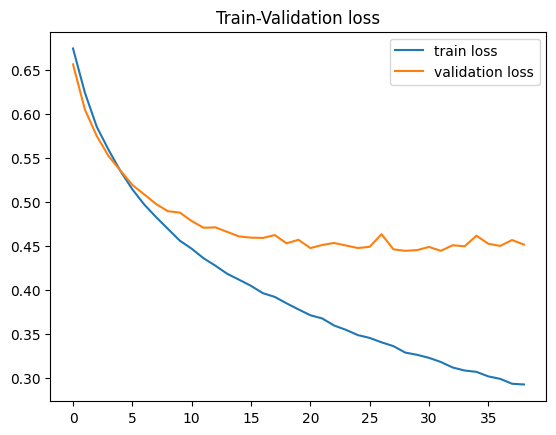

In [54]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_about2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [55]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.615, 'male': 0.8515625, 'average': 0.73328125}
precision {'female': 0.8118811881188119, 'male': 0.6798336798336798, 'average': 0.7458574339762458}
f1 {'female': 0.6998577524893315, 'male': 0.7560693641618497, 'average': 0.7279635583255906}
accuracy 0.7308673469387755


Evaluación en el conjunto el conjunto to
recall {'female': 0.42782152230971127, 'male': 0.7226277372262774, 'average': 0.5752246297679944}
precision {'female': 0.5884476534296029, 'male': 0.5766990291262136, 'average': 0.5825733412779083}
f1 {'female': 0.4954407294832827, 'male': 0.6414686825053996, 'average': 0.5684547059943411}
accuracy 0.5808080808080808


Evaluación en el conjunto el conjunto as
recall {'female': 0.49326145552560646, 'male': 0.7171717171717171, 'average': 0.6052165863486618}
precision {'female': 0.6203389830508474, 'male': 0.6016949152542372, 'average': 0.6110169491525423}
f1 {'female': 0.5495495495495495, 'male': 0.6543778801843317, '

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6755573631163674 	 Validation loss: 0.6578439817590228 	 
  1%|          | 574/57400 [00:09<16:02, 59.07it/s]
Epoch 2 	 Training loss: 0.6255881156032509 	 Validation loss: 0.6100072173748986 	 
  2%|▏         | 1148/57400 [00:19<14:39, 63.93it/s]
Epoch 3 	 Training loss: 0.5893463186582206 	 Validation loss: 0.5784355068610887 	 
  3%|▎         | 1722/57400 [00:28<13:49, 67.11it/s]
Epoch 4 	 Training loss: 0.5629095611152749 	 Validation loss: 0.5580287515106848 	 
  4%|▍         | 2296/57400 [00:37<14:14, 64.51it/s]
Epoch 5 	 Training loss: 0.5394239247052927 	 Validation loss: 0.5450851078760826 	 
  5%|▌         | 2870/57400 [00:46<13:32, 67.15it/s]
Epoch 6 	 Training loss: 0.5192521763284031 	 Validation loss: 0.5229536012067633 	 
  6%|▌         | 3444/57400 [00:56<13:49, 65.03it/s]
Epoch 7 	 Training loss: 0.5003748381387066 	 Validation loss: 0.5099607362585553 	 
  7%|▋         | 4018/57400 [01:05<13:42, 64.93it/s]
Epoch 8 	 Training loss: 0.48466737

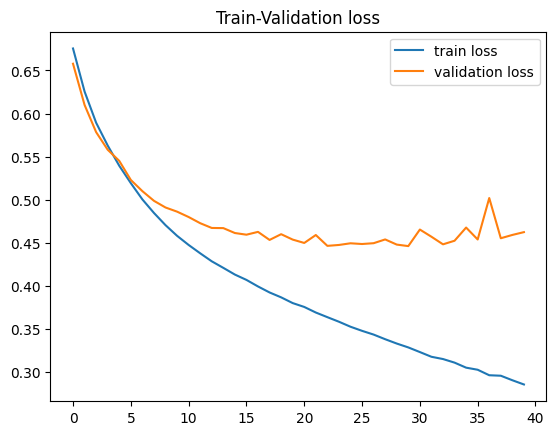

In [56]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_about3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [57]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.6075, 'male': 0.859375, 'average': 0.7334375}
precision {'female': 0.8181818181818182, 'male': 0.6776180698151951, 'average': 0.7478999439985067}
f1 {'female': 0.6972740315638452, 'male': 0.7577497129735935, 'average': 0.7275118722687193}
accuracy 0.7308673469387755


Evaluación en el conjunto el conjunto to
recall {'female': 0.45144356955380577, 'male': 0.7420924574209246, 'average': 0.5967680134873652}
precision {'female': 0.6187050359712231, 'male': 0.5933852140077821, 'average': 0.6060451249895026}
f1 {'female': 0.5220030349013657, 'male': 0.6594594594594594, 'average': 0.5907312471804125}
accuracy 0.6022727272727273


Evaluación en el conjunto el conjunto as
recall {'female': 0.5040431266846361, 'male': 0.6919191919191919, 'average': 0.597981159301914}
precision {'female': 0.6051779935275081, 'male': 0.5982532751091703, 'average': 0.6017156343183392}
f1 {'female': 0.55, 'male': 0.6416861826697892, 'average': 0.59584

In [58]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.7315849088994034
f1 etiqueta male: 0.7582380826415357
f1 etiqueta female:  0.7049317351572713


TO
Resultado global f1: 0.5809724218223709
f1 etiqueta male: 0.6464403330359054
f1 etiqueta female:  0.5155045106088363


AS
Resultado global f1: 0.6055525551736953
f1 etiqueta male: 0.6518878639038668
f1 etiqueta female:  0.5592172464435238


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.7365972222222222
recall etiqueta male: 0.8506944444444444
recall etiqueta female:  0.6225


TO
Resultado global recall: 0.5862565536972112
recall etiqueta male: 0.7201946472019465
recall etiqueta female:  0.45231846019247596


AS
Resultado global recall: 0.607859820123971
recall etiqueta male: 0.7053872053872053
recall etiqueta female:  0.5103324348607368


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.7484859735550947
precision etiqueta male: 0.6840251351876178
precision etiqueta female:  0.8129468119225

## TO

In [59]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693609410254382 	 Validation loss: 0.6925387534044557 	 
  1%|          | 574/57400 [00:10<16:01, 59.11it/s]
Epoch 2 	 Training loss: 0.6933748755305487 	 Validation loss: 0.6925392757027836 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<15:02, 62.35it/s]
Epoch 3 	 Training loss: 0.6933885252018839 	 Validation loss: 0.6947629027447458 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:30<15:43, 59.03it/s]
Epoch 4 	 Training loss: 0.6930952066951512 	 Validation loss: 0.6927140688492079 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:39<15:10, 60.50it/s]
Epoch 5 	 Training loss: 0.6930241683426634 	 Validation loss: 0.6930778218527972 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:49<15:03, 60.33it/s]
Epoch 6 	 Training loss: 0.6929640848877539 	 Validation loss: 0.6935726040500706 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:59<15:00, 59.90it/s]
Epoch 7 	 Training loss: 0.69

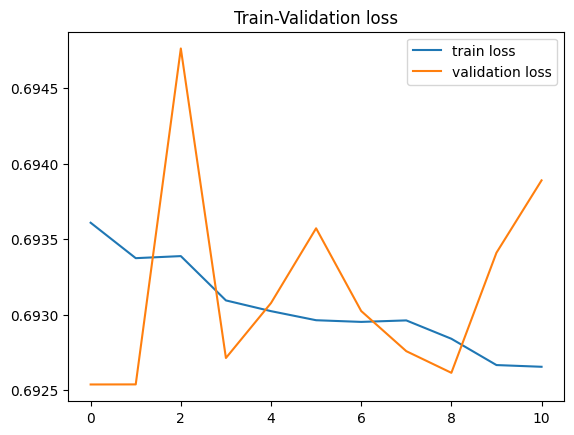

In [60]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_to'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [61]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.78, 'male': 0.20833333333333334, 'average': 0.4941666666666667}
precision {'female': 0.5064935064935064, 'male': 0.47619047619047616, 'average': 0.4913419913419913}
f1 {'female': 0.6141732283464567, 'male': 0.28985507246376807, 'average': 0.4520141504051124}
accuracy 0.5


Evaluación en el conjunto el conjunto to
recall {'female': 0.8031496062992126, 'male': 0.22141119221411193, 'average': 0.5122803992566622}
precision {'female': 0.48881789137380194, 'male': 0.5481927710843374, 'average': 0.5185053312290697}
f1 {'female': 0.6077457795431978, 'male': 0.3154246100519931, 'average': 0.4615851947975954}
accuracy 0.5012626262626263


Evaluación en el conjunto el conjunto as
recall {'female': 0.8113207547169812, 'male': 0.17676767676767677, 'average': 0.494044215742329}
precision {'female': 0.4800637958532695, 'male': 0.5, 'average': 0.49003189792663476}
f1 {'female': 0.6032064128256514, 'male': 0.26119402985074625, 'average':

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936436808483111 	 Validation loss: 0.693544841418832 	 
  1%|          | 574/57400 [00:09<16:08, 58.65it/s]
Epoch 2 	 Training loss: 0.6933552165895389 	 Validation loss: 0.6934607503777843 	 
  2%|▏         | 1148/57400 [00:19<15:30, 60.48it/s]
Epoch 3 	 Training loss: 0.6931233828699132 	 Validation loss: 0.6927338818372306 	 
  3%|▎         | 1722/57400 [00:29<15:10, 61.13it/s]
Epoch 4 	 Training loss: 0.6931238330199744 	 Validation loss: 0.6940179568226055 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:39<14:40, 62.61it/s]
Epoch 5 	 Training loss: 0.6929282386128496 	 Validation loss: 0.6930372290692087 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:49<15:09, 59.92it/s]
Epoch 6 	 Training loss: 0.6928552519984361 	 Validation loss: 0.6938246074369399 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:59<14:42, 61.16it/s]
Epoch 7 	 Training loss: 0.6926813348868167 	 Validation loss: 0.695644339262429 	 

4 

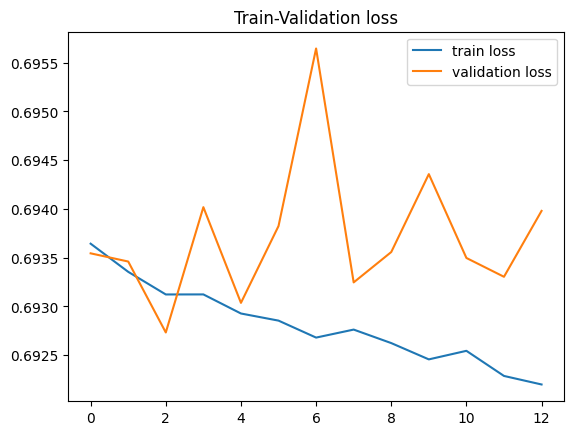

In [62]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_to2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [63]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.935, 'male': 0.0390625, 'average': 0.48703125}
precision {'female': 0.5033647375504711, 'male': 0.36585365853658536, 'average': 0.4346091980435282}
f1 {'female': 0.6544181977252844, 'male': 0.07058823529411765, 'average': 0.362503216509701}
accuracy 0.4961734693877551


Evaluación en el conjunto el conjunto to
recall {'female': 0.9553805774278216, 'male': 0.0340632603406326, 'average': 0.49472191888422706}
precision {'female': 0.4783180026281209, 'male': 0.45161290322580644, 'average': 0.4649654529269637}
f1 {'female': 0.637478108581436, 'male': 0.06334841628959276, 'average': 0.3504132624355144}
accuracy 0.4772727272727273


Evaluación en el conjunto el conjunto as
recall {'female': 0.9703504043126685, 'male': 0.027777777777777776, 'average': 0.49906409104522315}
precision {'female': 0.48322147651006714, 'male': 0.5, 'average': 0.49161073825503354}
f1 {'female': 0.6451612903225807, 'male': 0.05263157894736842, 'average'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935143706482877 	 Validation loss: 0.692482795755742 	 
  1%|          | 574/57400 [00:09<15:31, 61.02it/s]
Epoch 2 	 Training loss: 0.6933829955730704 	 Validation loss: 0.6936043389772965 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:19<15:27, 60.65it/s]
Epoch 3 	 Training loss: 0.6931248214809737 	 Validation loss: 0.6933347097897934 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:29<16:00, 58.00it/s]
Epoch 4 	 Training loss: 0.6929731577738653 	 Validation loss: 0.6934698042223009 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:39<14:40, 62.62it/s]
Epoch 5 	 Training loss: 0.692998051331849 	 Validation loss: 0.6931802670834428 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:44, 61.62it/s]
Epoch 6 	 Training loss: 0.6927947416538145 	 Validation loss: 0.6928416419837434 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:59<14:12, 63.29it/s]
Epoch 7 	 Training loss: 0.692

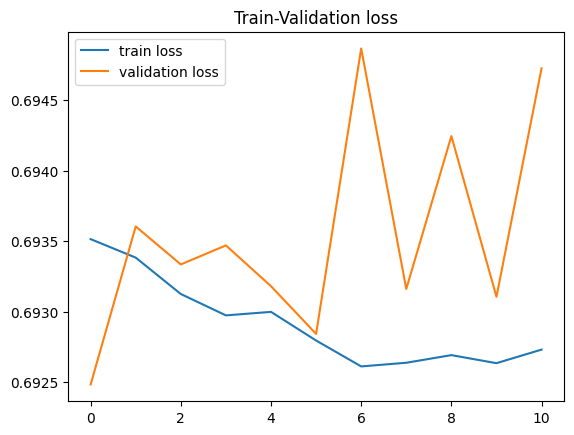

In [64]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_to3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [65]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.725, 'male': 0.3541666666666667, 'average': 0.5395833333333333}
precision {'female': 0.5390334572490706, 'male': 0.5528455284552846, 'average': 0.5459394928521776}
f1 {'female': 0.6183368869936033, 'male': 0.43174603174603177, 'average': 0.5250414593698176}
accuracy 0.5433673469387755


Evaluación en el conjunto el conjunto to
recall {'female': 0.7034120734908137, 'male': 0.31143552311435524, 'average': 0.5074237983025844}
precision {'female': 0.4863883847549909, 'male': 0.5311203319502075, 'average': 0.5087543583525992}
f1 {'female': 0.5751072961373391, 'male': 0.39263803680981596, 'average': 0.4838726664735775}
accuracy 0.5


Evaluación en el conjunto el conjunto as
recall {'female': 0.692722371967655, 'male': 0.3055555555555556, 'average': 0.49913896376160527}
precision {'female': 0.4830827067669173, 'male': 0.5148936170212766, 'average': 0.4989881618940969}
f1 {'female': 0.5692137320044296, 'male': 0.3835182250396197

In [66]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.4465196087615437
f1 etiqueta male: 0.2640631131679725
f1 etiqueta female:  0.6289761043551149


TO
Resultado global f1: 0.43195704123556244
f1 etiqueta male: 0.25713702105046726
f1 etiqueta female:  0.6067770614206577


AS
Resultado global f1: 0.4191542114983993
f1 etiqueta male: 0.23244794461257812
f1 etiqueta female:  0.6058604783842205


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5069270833333334
recall etiqueta male: 0.20052083333333334
recall etiqueta female:  0.8133333333333334


TO
Resultado global recall: 0.5048087054811579
recall etiqueta male: 0.18896999188969993
recall etiqueta female:  0.820647419072616


AS
Resultado global recall: 0.4974157568497191
recall etiqueta male: 0.17003367003367004
recall etiqueta female:  0.8247978436657682


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.4906302274125657
precision etiqueta male: 0.46496322106078203
precision etiqueta female

## AS

In [67]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936082744432244 	 Validation loss: 0.6933247467218819 	 
  1%|          | 574/57400 [00:09<15:10, 62.39it/s]
Epoch 2 	 Training loss: 0.6934777466054577 	 Validation loss: 0.6935426340264789 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:19<15:13, 61.56it/s]
Epoch 3 	 Training loss: 0.693340321451114 	 Validation loss: 0.6925291075544843 	 
  3%|▎         | 1722/57400 [00:29<15:12, 61.04it/s]
Epoch 4 	 Training loss: 0.6930223220524472 	 Validation loss: 0.6931408168905873 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:39<14:52, 61.76it/s]
Epoch 5 	 Training loss: 0.6927745770078918 	 Validation loss: 0.6945302769289179 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:54, 60.98it/s]
Epoch 6 	 Training loss: 0.692657749931156 	 Validation loss: 0.6929074647062916 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:58<14:22, 62.59it/s]
Epoch 7 	 Training loss: 0.6923583073067748 	 Validation lo

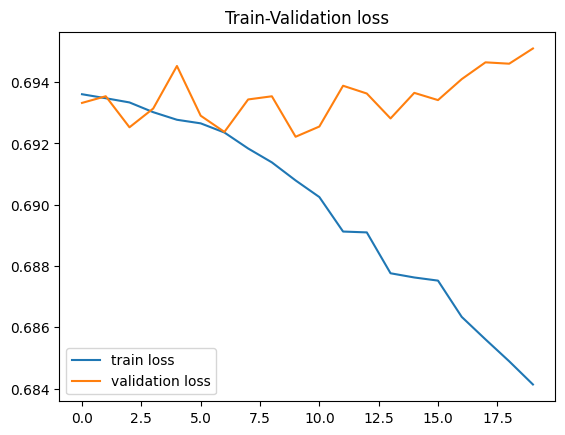

In [68]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_as'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [69]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.3275, 'male': 0.6770833333333334, 'average': 0.5022916666666667}
precision {'female': 0.5137254901960784, 'male': 0.4914933837429111, 'average': 0.5026094369694948}
f1 {'female': 0.39999999999999997, 'male': 0.5695509309967142, 'average': 0.48477546549835704}
accuracy 0.4987244897959184


Evaluación en el conjunto el conjunto to
recall {'female': 0.2992125984251969, 'male': 0.6690997566909975, 'average': 0.4841561775580972}
precision {'female': 0.456, 'male': 0.507380073800738, 'average': 0.48169003690036905}
f1 {'female': 0.36133122028526155, 'male': 0.5771248688352572, 'average': 0.46922804456025935}
accuracy 0.4911616161616162


Evaluación en el conjunto el conjunto as
recall {'female': 0.3288409703504043, 'male': 0.6994949494949495, 'average': 0.5141679599226769}
precision {'female': 0.5062240663900415, 'male': 0.526615969581749, 'average': 0.5164200179858953}
f1 {'female': 0.39869281045751637, 'male': 0.600867678958

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693646699086299 	 Validation loss: 0.6927502741247921 	 
  1%|          | 574/57400 [00:09<15:10, 62.39it/s]
Epoch 2 	 Training loss: 0.6933572941333159 	 Validation loss: 0.6920199384123592 	 
  2%|▏         | 1148/57400 [00:19<15:18, 61.21it/s]
Epoch 3 	 Training loss: 0.6932677636993887 	 Validation loss: 0.6923052618059061 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:29<14:49, 62.57it/s]
Epoch 4 	 Training loss: 0.6931915905209783 	 Validation loss: 0.6937778632519609 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:39<14:54, 61.61it/s]
Epoch 5 	 Training loss: 0.6926688244533871 	 Validation loss: 0.6926620653120138 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:42, 61.79it/s]
Epoch 6 	 Training loss: 0.692809134721756 	 Validation loss: 0.6933930657677732 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:58<14:51, 60.51it/s]
Epoch 7 	 Training loss: 0.6924544522986594 	 Validation lo

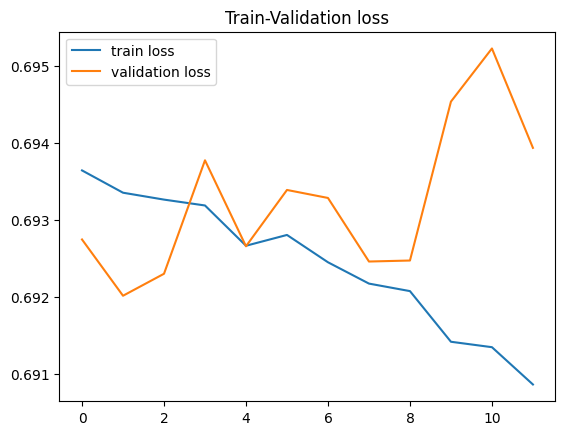

In [70]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_as2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [71]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.9875, 'male': 0.026041666666666668, 'average': 0.5067708333333334}
precision {'female': 0.5136540962288687, 'male': 0.6666666666666666, 'average': 0.5901603814477676}
f1 {'female': 0.6757912745936699, 'male': 0.050125313283208024, 'average': 0.362958293938439}
accuracy 0.5165816326530612


Evaluación en el conjunto el conjunto to
recall {'female': 0.9921259842519685, 'male': 0.009732360097323601, 'average': 0.500929172174646}
precision {'female': 0.48152866242038217, 'male': 0.5714285714285714, 'average': 0.5264786169244768}
f1 {'female': 0.6483704974271013, 'male': 0.019138755980861247, 'average': 0.33375462670398126}
accuracy 0.4823232323232323


Evaluación en el conjunto el conjunto as
recall {'female': 0.9892183288409704, 'male': 0.0025252525252525255, 'average': 0.49587179068311144}
precision {'female': 0.4816272965879265, 'male': 0.2, 'average': 0.34081364829396327}
f1 {'female': 0.64783759929391, 'male': 0.0049875

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934756256562077 	 Validation loss: 0.6952520134085316 	 
  1%|          | 574/57400 [00:09<15:39, 60.50it/s]
Epoch 2 	 Training loss: 0.6934102533794031 	 Validation loss: 0.6930023068088597 	 
  2%|▏         | 1148/57400 [00:19<15:29, 60.54it/s]
Epoch 3 	 Training loss: 0.6931432237400826 	 Validation loss: 0.6930339346497746 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:29<14:52, 62.39it/s]
Epoch 4 	 Training loss: 0.6929479163490522 	 Validation loss: 0.6918883071107379 	 
  4%|▍         | 2296/57400 [00:39<15:24, 59.58it/s]
Epoch 5 	 Training loss: 0.6928267045926549 	 Validation loss: 0.6961047477641348 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:49<15:10, 59.92it/s]
Epoch 6 	 Training loss: 0.6928038235740794 	 Validation loss: 0.6929317379401903 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:59<14:33, 61.77it/s]
Epoch 7 	 Training loss: 0.6925321055206273 	 Validation loss: 0.6943957795531063 	 



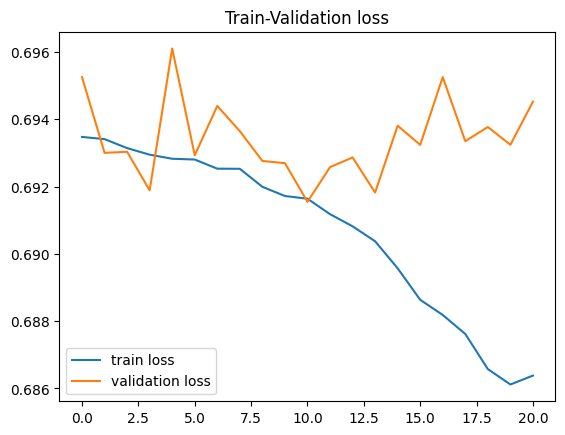

In [72]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_as3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [73]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.4875, 'male': 0.4505208333333333, 'average': 0.46901041666666665}
precision {'female': 0.4802955665024631, 'male': 0.4576719576719577, 'average': 0.4689837620872104}
f1 {'female': 0.48387096774193544, 'male': 0.4540682414698163, 'average': 0.4689696046058759}
accuracy 0.46938775510204084


Evaluación en el conjunto el conjunto to
recall {'female': 0.5301837270341208, 'male': 0.559610705596107, 'average': 0.5448972163151139}
precision {'female': 0.5274151436031331, 'male': 0.5623471882640587, 'average': 0.5448811659335959}
f1 {'female': 0.5287958115183246, 'male': 0.5609756097560976, 'average': 0.5448857106372111}
accuracy 0.5454545454545454


Evaluación en el conjunto el conjunto as
recall {'female': 0.5471698113207547, 'male': 0.5, 'average': 0.5235849056603774}
precision {'female': 0.5062344139650873, 'male': 0.5409836065573771, 'average': 0.5236090102612322}
f1 {'female': 0.5259067357512953, 'male': 0.5196850393700788

In [74]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.4389011213475573
f1 etiqueta male: 0.35791482858324614
f1 etiqueta female:  0.5198874141118685


TO
Resultado global f1: 0.44928946063381725
f1 etiqueta male: 0.385746411524072
f1 etiqueta female:  0.5128325097435624


AS
Resultado global f1: 0.4496628991672759
f1 etiqueta male: 0.375180083166978
f1 etiqueta female:  0.5241457151675739


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.49269097222222225
recall etiqueta male: 0.3845486111111111
recall etiqueta female:  0.6008333333333333


TO
Resultado global recall: 0.509994188682619
recall etiqueta male: 0.4128142741281427
recall etiqueta female:  0.6071741032370954


AS
Resultado global recall: 0.5112082187553886
recall etiqueta male: 0.4006734006734007
recall etiqueta female:  0.6217430368373764


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5205845268348243
precision etiqueta male: 0.5386106693605118
precision etiqueta female:  0.5